In [ ]:
!pip3 install transformers

# Work towards a better model, language trained on news and with targets filtered and handpicked news from our database


In [ ]:
import pandas as pd
import numpy as np

import pickle

from transformers import TFBertModel, BertTokenizer


from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
with open('/content/drive/MyDrive/abnormal-distribution-project-data/lean/final_train.p','rb') as pkl_file:
  train_df = pickle.load(pkl_file)
with open('/content/drive/MyDrive/abnormal-distribution-project-data/lean/final_valid.p','rb') as pkl_file:
  valid_df = pickle.load(pkl_file)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('ipuneetrathore/bert-base-cased-finetuned-finBERT')

In [ ]:
outputs = tokenizer.batch_encode_plus(
        train_df.text.to_list(),
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=512, # max length of the text that can go to BERT (<=512)
        return_attention_mask = True,
        truncation='longest_first'
    )

In [ ]:
outputs_valid = tokenizer.batch_encode_plus(
        valid_df.text.to_list(),
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=512, # max length of the text that can go to BERT (<=512)
        return_attention_mask = True,
        truncation='longest_first'
    )

In [ ]:
# Build Model to get hidden layers
def get_finBERT_hidden():

    # Inputs layers
    input_ids = layers.Input(shape=(512,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(512,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(512,), dtype=tf.int32)

    # BERT model
    bert = TFBertModel.from_pretrained(
        'ipuneetrathore/bert-base-cased-finetuned-finBERT',
        return_dict=True,
        from_pt = True
    )

    # BERT is not trainable
    bert.trainable = False

    # BERT output
    question = bert(
        input_ids, 
        token_type_ids=token_type_ids, 
        attention_mask=attention_mask
    )

    # Pooled Output
    output = layers.Flatten()(question[1])

    # Build the model
    model = Model(
        inputs=[input_ids, token_type_ids, attention_mask], 
        outputs=output
    )

    return model

  # Function for threading model
def get_finmodel_output(model_hs, input, score):
    pred_y_hs = model_hs.predict(input)

    temp_df = pd.DataFrame(
        {
         'bert_features': list(pred_y_hs),
         'score': score
         })

    return temp_df

def create_model():
  input = layers.Input(shape=(768,), dtype=tf.float32)
  x = layers.Dropout(0.3)(input)
  #x = layers.Dense(1024, 'relu')(x)
  output = layers.Dense(3, activation='softmax')(x)

  model = Model(inputs=input, outputs=output)

  return model

    

def evaluate_model(model, model_name, test_data, training_results, learning_rate, epochs, 
                   optimizer,save=False, loss_metrics=["loss","val_loss"], 
                   acc_metrics=["accuracy","val_accuracy"]):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]
  
  if save:
      # Save model
      model.save(os.path.join("/content/drive/My Drive/abnormal-distribution-project-data/lean/models/",model_name))
      
  return evaluation_results

In [ ]:
model_hs = get_finBERT_hidden()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices(((outputs['input_ids'],
                                                     outputs['token_type_ids'],
                                                     outputs['attention_mask']),train_df.score))

dataset_valid = tf.data.Dataset.from_tensor_slices(((outputs_valid['input_ids'],
                                                     outputs_valid['token_type_ids'],
                                                     outputs_valid['attention_mask']),valid_df.score))

In [ ]:
df_outputs = pd.DataFrame()
for input, score in tqdm(dataset_train.batch(256)):

  temp_df = get_finmodel_output(model_hs, input , score)
  df_outputs = pd.concat([df_outputs, temp_df])

pickle.dump(df_outputs, 
            open('/content/drive/MyDrive/abnormal-distribution-project-data/lean/final_train_hs.p','wb'))

In [ ]:
df_outputs = pd.DataFrame()
for input, score in tqdm(dataset_valid.batch(256)):

  temp_df = get_finmodel_output(model_hs, input , score)
  df_outputs = pd.concat([df_outputs, temp_df])

pickle.dump(df_outputs, 
            open('/content/drive/MyDrive/abnormal-distribution-project-data/lean/final_valid_hs.p','wb'))

In [ ]:
with open('/content/drive/MyDrive/abnormal-distribution-project-data/lean/final_train_hs.p','rb') as pkl_file:
  train_df = pickle.load(pkl_file)
with open('/content/drive/MyDrive/abnormal-distribution-project-data/lean/final_valid_hs.p','rb') as pkl_file:
  valid_df = pickle.load(pkl_file)

train_df = train_df.sample(frac=1)


In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((train_df.bert_features.to_list(),
                                                    train_df.score)).batch(1).take(10000)

dataset_valid = tf.data.Dataset.from_tensor_slices((valid_df.bert_features.to_list(),
                                                    valid_df.score)).batch(1)

10000/10000 [==============================] - 47s 5ms/step - loss: 0.5657 - accuracy: 0.9937 - val_loss: 0.5550 - val_accuracy: 0.9978


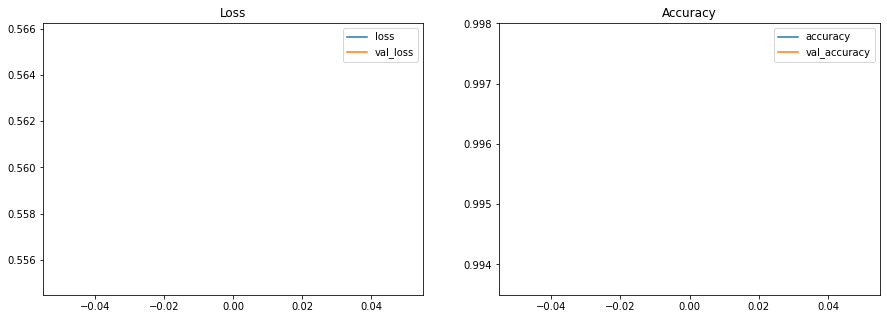

20000/20000 [==============================] - 30s 1ms/step - loss: 0.5550 - accuracy: 0.9978
{'loss': 0.5550242066383362, 'accuracy': 0.9977999925613403}


In [ ]:
learning_rate=3e-5

bert = create_model()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

bert.compile(optimizer=optimizer, loss=loss, metrics=metrics)

training_results = bert.fit(dataset_train,
                            validation_data=dataset_valid, 
                            epochs=1,
                            verbose=1,
)

result = evaluate_model(bert, "model", dataset_valid, training_results, learning_rate, epochs=1, optimizer=optimizer, save=False)

In [ ]:
news = []
f = open("/content/drive/MyDrive/abnormal-distribution-project-data/finphrase/Sentences_50Agree.txt", "r", encoding='latin-1')
for x in f:
    news.append(x)
    
print(len(news))

neutral = [n.strip('@neutral\n') for n in news if '@neutral' in n]
positive= [n.strip('@positive\n') for n in news if '@positive' in n]
negative= [n.strip('@negative\n') for n in news if '@negative' in n]

4846


In [ ]:
all_news = neutral + positive + negative
labels = [[1]]*len(neutral) + [[2]]*len(positive) + [[0]]*len(negative)

outputs = tokenizer.batch_encode_plus(
        all_news,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=512, # max length of the text that can go to BERT (<=512)
        return_attention_mask = True,
        truncation='longest_first'
    )

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices(((outputs['input_ids'],
                                                     outputs['token_type_ids'],
                                                     outputs['attention_mask']),labels))

In [ ]:
df_outputs = pd.DataFrame()
for input, score in tqdm(dataset_test.batch(256)):

  temp_df = get_finmodel_output(model_hs, input , score)
  df_outputs = pd.concat([df_outputs, temp_df])

NameError: ignored

In [ ]:
dataset_test = tf.data.Dataset.from_tensor_slices((df_outputs.bert_features.to_list(),
                                                    labels)).batch(1)

In [ ]:
preds = []
for d1,d2 in tqdm(dataset_test):
  preds.append(bert.predict(d1))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(pp, labels)

0.9987618654560462

In [ ]:
test_hs = pickle.load(open('/content/drive/MyDrive/abnormal-distribution-project-data/lean/test_hs_news.p','rb'))
dataset_test = tf.data.Dataset.from_tensor_slices(test_hs.bert_features.to_list())


In [ ]:
#bert = create_model()
#bert.load_weights('/content/drive/MyDrive/abnormal-distribution-project-data/lean/best/checkpoint')

In [ ]:
preds = []
for d in tqdm(dataset_test.batch(256)):
  preds.append(bert.predict(d))

In [ ]:
preds_list = []
for p in preds:
  preds_list += list(p.argmax(axis=1))

In [ ]:
test_hs = pd.DataFrame(test_hs)
test_hs['score'] = preds_list

In [ ]:
test_hs.to_csv('/content/drive/MyDrive/abnormal-distribution-project-data/lean/please_work.csv',index=False)

In [ ]:
bert = TFBertForSequenceClassification.from_pretrained(
    'ipuneetrathore/bert-base-cased-finetuned-finBERT',
    #'bert-base-uncased',
    #'/content/drive/MyDrive/abnormal-distribution-project-data/lean/models/checkpoint-100000',
    num_labels=3,
    from_pt=True)

bert.layers[2].set_weights([bert.layers[2].get_weights()[0]*0, bert.layers[2].get_weights()[1]*0])
bert.bert.trainable=False

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

bert.compile(optimizer=optimizer, loss = loss, metrics=metrics)

In [ ]:
bert.fit(
    dataset.batch(4).shuffle(5000), 
    epochs=2,
    verbose=1,
)

In [ ]:
bert.save_weights('/content/drive/MyDrive/abnormal-distribution-project-data/lean/')

In [ ]:
nlp = pipeline('sentiment-analysis', model='ipuneetrathore/bert-base-cased-finetuned-finBERT')

neutral_preds=[]
for n in tqdm(neutral):
  neutral_preds.append(nlp(n))

positive_preds=[]
for n in tqdm(positive):
  positive_preds.append(nlp(n))

negative_preds=[]
for n in tqdm(positive):
  negative_preds.append(nlp(n))
zx
neutral_sum = sum([1 for n in neutral_preds if n[0]['label']=='LABEL_1'])
positive_sum = sum([1 for n in positive_preds if n[0]['label']=='LABEL_2'])
negative_sum = sum([1 for n in negative_preds if n[0]['label']=='LABEL_0'])

(neutral_sum + positive_sum + negative_sum)/len(news)

In [ ]:
from transformers import TFRobertaForSequenceClassification
model = TFRobertaForSequenceClassification.from_pretrained(“roberta-base”)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy(‘accuracy’)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.fit(ds_train_encoded, 
          epochs=number_of_epochs, 
          validation_data=ds_test_encoded, 
          callbacks=[metrics])

In [ ]:
, TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf
import numpy as np

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import pipeline

from tqdm.notebook import tqdm

In [ ]:
news = []
f = open("/content/drive/MyDrive/abnormal-distribution-project-data/finphrase/Sentences_50Agree.txt", "r", encoding='latin-1')
for x in f:
    news.append(x)
    
print(len(news))

neutral = [n.strip('@neutral\n') for n in news if '@neutral' in n]
positive= [n.strip('@positive\n') for n in news if '@positive' in n]
negative= [n.strip('@negative\n') for n in news if '@negative' in n]

In [ ]:
nlp = pipeline('sentiment-analysis', model='ipuneetrathore/bert-base-cased-finetuned-finBERT')

neutral_preds=[]
for n in tqdm(neutral):
  neutral_preds.append(nlp(n))

positive_preds=[]
for n in tqdm(positive):
  positive_preds.append(nlp(n))

negative_preds=[]
for n in tqdm(positive):
  negative_preds.append(nlp(n))
zx
neutral_sum = sum([1 for n in neutral_preds if n[0]['label']=='LABEL_1'])
positive_sum = sum([1 for n in positive_preds if n[0]['label']=='LABEL_2'])
negative_sum = sum([1 for n in negative_preds if n[0]['label']=='LABEL_0'])

(neutral_sum + positive_sum + negative_sum)/len(news)

0.8743293437886918

In [ ]:
nlp = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment')

neutral_preds=[]
for n in tqdm(neutral):
  neutral_preds.append(nlp(n))

positive_preds=[]
for n in tqdm(positive):
  positive_preds.append(nlp(n))

negative_preds=[]
for n in tqdm(positive):
  negative_preds.append(nlp(n))
zx
neutral_sum = sum([1 for n in neutral_preds if n[0]['label']=='LABEL_1'])
positive_sum = sum([1 for n in positive_preds if n[0]['label']=='LABEL_2'])
negative_sum = sum([1 for n in negative_preds if n[0]['label']=='LABEL_0'])

(neutral_sum + positive_sum + negative_sum)/len(news)

0.6300041271151465

In [ ]:
nlp = pipeline('sentiment-analysis', model='ipuneetrathore/bert-base-cased-finetuned-finBERT')

neutral_preds=[]
for n in tqdm(neutral):
  neutral_preds.append(nlp(n))

positive_preds=[]
for n in tqdm(positive):
  positive_preds.append(nlp(n))

negative_preds=[]
for n in tqdm(positive):
  negative_preds.append(nlp(n))
zx
neutral_sum = sum([1 for n in neutral_preds if n[0]['label']=='LABEL_1'])
positive_sum = sum([1 for n in positive_preds if n[0]['label']=='LABEL_2'])
negative_sum = sum([1 for n in negative_preds if n[0]['label']=='LABEL_0'])

(neutral_sum + positive_sum + negative_sum)/len(news)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('ipuneetrathore/bert-base-cased-finetuned-finBERT')
bert = TFBertForSequenceClassification.from_pretrained(
    #'ipuneetrathore/bert-base-cased-finetuned-finBERT',
    #'bert-base-uncased',
    '/content/drive/MyDrive/abnormal-distribution-project-data/lean/models/checkpoint-100000',
    num_labels=3,
    from_pt=True)

bert.bert.trainable=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from t

4846


In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('ipuneetrathore/bert-base-cased-finetuned-finBERT')

In [ ]:
outputs = tokenizer.batch_encode_plus(
        train.text.to_list(),
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=512, # max length of the text that can go to BERT (<=512)
        return_attention_mask = True,
        truncation='longest_first'
    )

In [ ]:
tokenizer = BertTokenizer.from_pretrained('ipuneetrathore/bert-base-cased-finetuned-finBERT')
bert = TFBertForSequenceClassification.from_pretrained(
    'ipuneetrathore/bert-base-cased-finetuned-finBERT',
    #'bert-base-uncased',
    #'/content/drive/MyDrive/abnormal-distribution-project-data/lean/models/checkpoint-100000',
    num_labels=3,
    from_pt=True)

bert.layers[2].set_weights([bert.layers[2].get_weights()[0]*0, bert.layers[2].get_weights()[1]*0])
bert.bert.trainable=False

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
